# **Import File From Local**

In [4]:
import zipfile as zf

files = zf.ZipFile("Dataset BISINDO.zip",'r')
files.extractall()
files.close()

In [5]:
#Set Parameter
batch_size = 32     # set ukuran size
img_height = 224    # untuk set panjang image
img_width = 224    # untuk set panjang image

In [6]:
import tensorflow as tf

print(len(tf.config.list_physical_devices('GPU')))

0


# **Split The Data To Training and Validation**

In [7]:
!nvidia-smi

Thu Jun 15 14:47:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              27W /  80W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('Dataset Bisindo/datatrain')
test_dir = Path('Dataset Bisindo/datatest')

# Get the filepaths and labels for the training data
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
train_labels = [path.parent.name for path in train_filepaths]

# Get the filepaths and labels for the test data
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
test_labels = [path.parent.name for path in test_filepaths]

# Create a DataFrame
df_train = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
df_test = pd.DataFrame({'Filepath': test_filepaths, 'Label': test_labels})

print("Number of images in df_train:", len(df_train))
print("Number of labels in df_train:", len(df_train['Label'].unique()))
print("Number of images in df_test:", len(df_test))
print("Number of labels in df_test:", len(df_test['Label'].unique()))
print("Classes in df_train:", df_train['Label'].unique())
print("Classes in df_test:", df_test['Label'].unique())

Number of images in df_train: 3229
Number of labels in df_train: 26
Number of images in df_test: 954
Number of labels in df_test: 26
Classes in df_train: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
Classes in df_test: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [9]:
df_train.head(10)

,Filepath,Label
0,Dataset Bisindo\datatrain\A\20210513_203203(0)...,A
1,Dataset Bisindo\datatrain\A\body dot (1).jpg,A
2,Dataset Bisindo\datatrain\A\body dot (2).jpg,A
3,Dataset Bisindo\datatrain\A\body dot (3).jpg,A
4,Dataset Bisindo\datatrain\A\body dot (4).jpg,A
5,Dataset Bisindo\datatrain\A\body white (1).jpg,A
6,Dataset Bisindo\datatrain\A\body white (2).jpg,A
7,Dataset Bisindo\datatrain\A\body white (3).jpg,A
8,Dataset Bisindo\datatrain\A\body white (4).jpg,A
9,Dataset Bisindo\datatrain\A\img_00001.jpg,A


# **Visualization The Data**

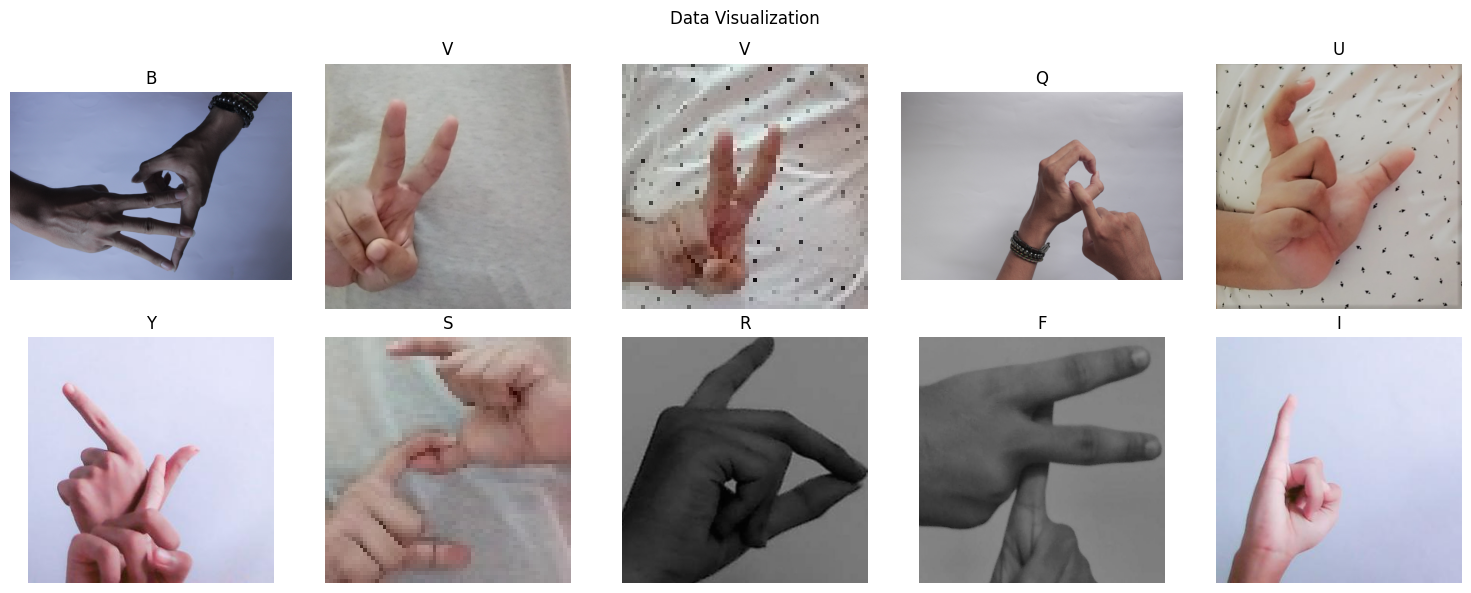

In [7]:
# Create a figure with subplots for visualization
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Visualization')

# Iterate over the train dataset and plot the images with labels
for i, (_, row) in enumerate(df_train.sample(5).iterrows()):
    image_path = row['Filepath']
    label = row['Label']
    image = plt.imread(str(image_path))
    axs[0, i].imshow(image)
    axs[0, i].set_title(label)
    axs[0, i].axis('off')

# Iterate over the test dataset and plot the images with labels
for i, (_, row) in enumerate(df_test.sample(5).iterrows()):
    image_path = row['Filepath']
    label = row['Label']
    image = plt.imread(str(image_path))
    axs[1, i].imshow(image)
    axs[1, i].set_title(label)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# **Modeling The Data**

In [8]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps = 20, decay_rate = 0.98, staircase = True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience = 10, restore_best_weights = True
)

In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    weights = 'imagenet', 
    input_shape = (img_width, img_height, 3), 
    include_top = False, 
    pooling = 'avg'
)

for layer in pre_trained_model.layers:
    layer.trainable = True

# See Pre Trained Model Summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [34]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [36]:
from tensorflow.keras import layers
from tensorflow.keras import Model

num_class = len(df_train['Label'].unique())

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(num_class, activation = 'softmax')(x)  

# Re-Create model

model = Model(inputs = pre_trained_model.input, outputs = x)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image data generator parameters for augmentation or preprocessing
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1 / 255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                 target_size=(img_height, img_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 3229 images belonging to 26 classes.
Found 954 images belonging to 26 classes.


In [38]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate = lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [40]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='model60.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# **Training The Data**

In [41]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks = [early_stopping_cb]
)

Epoch 1/20
103/103 [==============================] - 777s 7s/step - loss: 1.5934 - accuracy: 0.5560 - val_loss: 2.2247 - val_accuracy: 0.4846
Epoch 2/20
103/103 [==============================] - 721s 7s/step - loss: 0.3511 - accuracy: 0.8940 - val_loss: 1.7003 - val_accuracy: 0.6739
Epoch 3/20
103/103 [==============================] - 680s 7s/step - loss: 0.1605 - accuracy: 0.9472 - val_loss: 1.3423 - val_accuracy: 0.6749
Epoch 4/20
103/103 [==============================] - 687s 7s/step - loss: 0.1203 - accuracy: 0.9633 - val_loss: 1.1921 - val_accuracy: 0.7140
Epoch 5/20
103/103 [==============================] - 687s 7s/step - loss: 0.0832 - accuracy: 0.9748 - val_loss: 1.2312 - val_accuracy: 0.7140
Epoch 6/20
103/103 [==============================] - 724s 7s/step - loss: 0.0524 - accuracy: 0.9830 - val_loss: 1.2712 - val_accuracy: 0.7171
Epoch 7/20
103/103 [==============================] - 667s 6s/step - loss: 0.0396 - accuracy: 0.9875 - val_loss: 1.5025 - val_accuracy: 0.7037

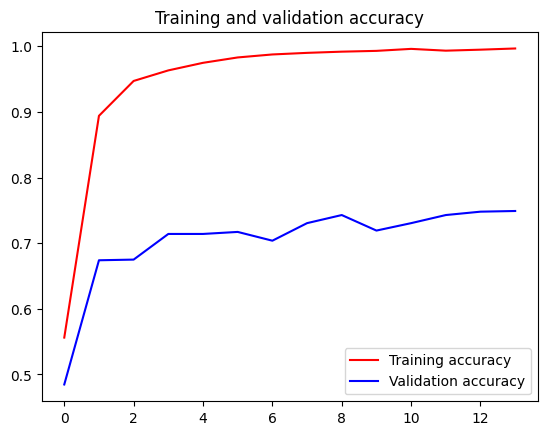

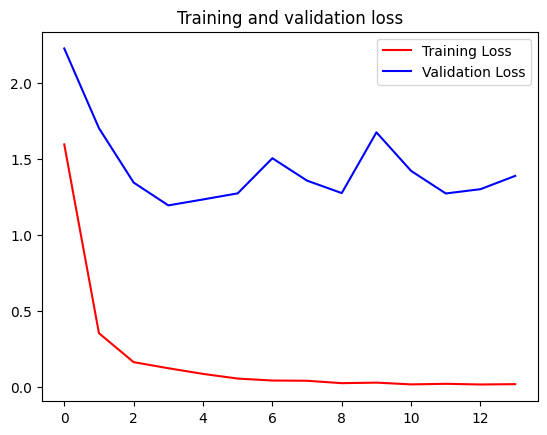

In [42]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

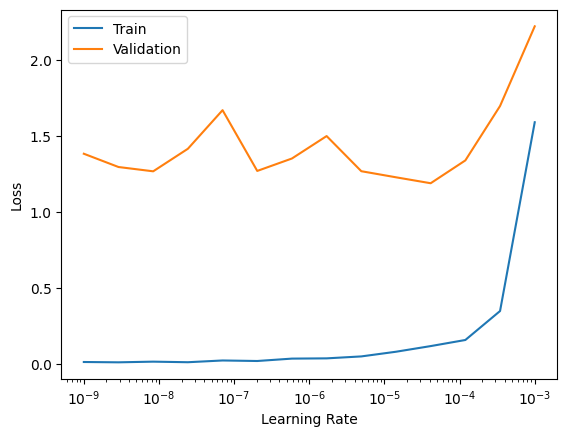

In [43]:
# Plot learning rate vs loss
lrs = 1e-3 * np.power(0.1, np.linspace(0, 6, len(history.history['loss'])))

plt.semilogx(lrs, history.history['loss'])
plt.semilogx(lrs, history.history['val_loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [44]:
'''# Specify the path to save the model
model_path = "my_model_0.74/model.h5"

# Save the model
model.save(model_path)

# Print a message to confirm the save
print("Model saved at:", model_path)'''

Model saved at: my_model_0.74/model.h5
